In [1]:
import pandas as pd
import numpy as np
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import math
import plotly.express as px
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

2021-11-30 10:04:15.032649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 10:04:15.032715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_data_for_regression(filename, nrows=None):
	data = pd.read_csv(filename, nrows=nrows)
	# data.rename(columns={"CH": "Curah Hujan"}, inplace=True)
	return data

# PREPROCESSING DATA
def preprocessed_data(dataframe):
	# Fill missing values in QFF Column
	dataframe['QFF'].fillna(dataframe['QFF'].mean(), inplace=True)
	return dataframe

def split_dataset(dataset, test_ratio):
	test_indices = np.random.rand(len(dataset)) < test_ratio
	return dataset[~test_indices], dataset[test_indices]

def neural_network_model(features):
	normalizer = tf.keras.layers.Normalization(axis=-1)
	normalizer.adapt(np.array(features))
	model = tf.keras.Sequential([normalizer, 
									tf.keras.layers.Dense(256, activation=tf.nn.relu),
                  tf.keras.layers.Dropout(0.5),
									tf.keras.layers.Dense(256, activation=tf.nn.relu),
                  tf.keras.layers.Dropout(0.5),
									tf.keras.layers.Dense(128, activation=tf.nn.relu),
                  tf.keras.layers.Dropout(0.5),
									tf.keras.layers.Dense(1)])
	return model

def train_neural_network(dt_train_features, dt_train_labels, dt_test_features, dt_test_labels):
	early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
	model = neural_network_model(dt_train_features)
	model.compile(metrics=["mae", "mse"],
				        loss=["mean_absolute_error", "mean_squared_error"],
				        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	model.fit(dt_train_labels, dt_train_labels, validation_split=0.1, epochs=500, verbose=1, callbacks=[early_stop])
	evaluation = model.evaluate(dt_test_features, dt_test_labels, verbose=0)
	return model, evaluation

def random_forest_model():
	model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

	return model

def train_random_forest(train_dataframe, test_dataframe, str_label):
	train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=train_dataframe, 
													                         label=str_label,
													                         task=tfdf.keras.Task.REGRESSION)
	test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=test_dataframe,
                                                  label=str_label,
                                                  task=tfdf.keras.Task.REGRESSION)
	model = random_forest_model()
	model.compile(metrics=["mae", "mse"])
	model.fit(x=train_ds)
	evaluation = model.evaluate(test_ds, return_dict=True)
	return model, evaluation
	
def gradient_boosting_model():
	model = tfdf.keras.GradientBoostingModel(task=tfdf.keras.Task.REGRESSION)
	return model

def train_gradient_boosting(train_dataframe, test_dataframe, str_label):
	train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=train_dataframe, 
													 label=str_label,
													 task=tfdf.keras.Task.REGRESSION)
	test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=test_dataframe,
													label=str_label,
													task=tfdf.keras.Task.REGRESSION)
	model = gradient_boosting_model()
	model.compile(metrics=["mae", "mse"])
	model.fit(x=train_ds)
	evaluation = model.evaluate(test_ds, return_dict=True)
	return model, evaluation

In [4]:
dir = 'peramalan_cuaca_bmkg_dev/dataset/'
filename = 'fklim-ngrai-20112020-final.csv'
dirfile = os.path.join(dir, filename)
df = load_data_for_regression(filename=dirfile)
df = preprocessed_data(df)
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])
df.head()

,Date,Tahun,Bulan,Tanggal,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,...,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,1/1/2011,2011,1,1,25.1,27.0,26.4,25.9,29.0,24.7,...,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,2/1/2011,2011,1,2,26.4,30.6,26.9,27.6,30.6,25.5,...,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,3/1/2011,2011,1,3,25.4,30.3,26.0,26.8,31.2,24.8,...,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,4/1/2011,2011,1,4,25.2,28.6,28.3,26.8,29.5,24.4,...,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,5/1/2011,2011,1,5,24.6,30.8,27.2,26.8,31.7,24.1,...,1005.3,88,72,89,84,3,50,24.0,30,1010.36396


In [5]:
dropped_cols = ['Date', 'Tahun', 'Bulan', 'Tanggal', 'Cuaca Khusus']
df_pre = df.copy()
df_pre.drop(dropped_cols, axis=1, inplace=True)
df_pre.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,CH,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,1.0,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,26.4,30.6,26.9,27.6,30.6,25.5,0.8,46,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,0.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,0.0,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,24.6,30.8,27.2,26.8,31.7,24.1,5.3,71,1005.3,88,72,89,84,3,50,24.0,30,1010.36396


In [6]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=df_pre, test_ratio=0.2)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))
train_ds_pd.columns

2945 examples in training, 708 examples for testing.


Index(['T0700', 'T1300', 'T1800', 'Trata-rata', 'Tmax', 'Tmin', 'CH', 'LPM',
       'QFE', 'RH0700', 'RH1300', 'RH1800', 'RHrata-rata', 'ffrata-rata', 'dd',
       'ffmax', 'ddmax', 'QFF'],
      dtype='object')

In [7]:
train_ds_pd.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,CH,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,1.0,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,0.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,0.0,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,24.6,30.8,27.2,26.8,31.7,24.1,5.3,71,1005.3,88,72,89,84,3,50,24.0,30,1010.36396
5,25.4,30.0,28.4,27.3,30.8,24.5,21.8,63,1006.1,91,81,83,87,3,270,15.0,270,1010.36396


# Using Neural Network Deep Learning with Tensorflow 

In [8]:
feature_cols = df_pre.columns
label_col = ['CH']
feature_cols = [i for i in feature_cols if i not in label_col]

# Split features from labels
train_features = train_ds_pd[feature_cols].copy()
test_features = test_ds_pd[feature_cols].copy()
train_labels = train_ds_pd[label_col].copy()
test_labels = test_ds_pd[label_col].copy()

train_features.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,24.6,30.8,27.2,26.8,31.7,24.1,71,1005.3,88,72,89,84,3,50,24.0,30,1010.36396
5,25.4,30.0,28.4,27.3,30.8,24.5,63,1006.1,91,81,83,87,3,270,15.0,270,1010.36396


In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)
# test_features = scaler.fit_transform(test_features)
# train_labels = scaler.fit_transform(train_labels)
# test_labels = scaler.fit_transform(test_labels) 

In [9]:
# Show example normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

2021-11-30 10:05:21.900999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-30 10:05:21.902227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 10:05:21.902304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-30 10:05:21.902356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-30 10:05:21.902436: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

First example: [[  25.1    27.     26.4    25.9    29.     24.7    33.   1004.1    95.
    90.     86.     92.      3.     90.      8.     70.   1010.36]]

Normalized: [[-0.58 -1.86 -1.1  -1.21 -1.17 -0.06 -1.07 -2.73  1.62  2.87  1.51  2.52
  -1.31 -0.91 -1.8  -1.24  0.  ]]


In [10]:
tf.keras.backend.clear_session()
nn_model, evaluation = train_neural_network(dt_train_features=train_features, 
                                  dt_train_labels=train_labels, 
                                  dt_test_features=test_features, 
                                  dt_test_labels=test_labels)

Epoch 1/500
83/83 [==============================] - 1s 6ms/step - loss: 16.3544 - mae: 16.3544 - mse: 2657.4048 - val_loss: 3.1030 - val_mae: 3.1030 - val_mse: 53.4963
Epoch 2/500
83/83 [==============================] - 0s 4ms/step - loss: 3.2167 - mae: 3.2167 - mse: 97.2590 - val_loss: 2.0098 - val_mae: 2.0098 - val_mse: 18.6943
Epoch 3/500
83/83 [==============================] - 0s 4ms/step - loss: 3.0976 - mae: 3.0976 - mse: 90.7742 - val_loss: 1.6040 - val_mae: 1.6040 - val_mse: 11.8888
Epoch 4/500
83/83 [==============================] - 0s 5ms/step - loss: 3.3087 - mae: 3.3087 - mse: 150.1102 - val_loss: 2.7528 - val_mae: 2.7528 - val_mse: 31.8823
Epoch 5/500
83/83 [==============================] - 0s 5ms/step - loss: 3.3136 - mae: 3.3136 - mse: 106.6137 - val_loss: 3.3127 - val_mae: 3.3127 - val_mse: 65.2841
Epoch 6/500
83/83 [==============================] - 0s 5ms/step - loss: 3.4964 - mae: 3.4964 - mse: 207.0763 - val_loss: 3.0051 - val_mae: 3.0051 - val_mse: 50.2328
Epo

In [11]:
new_row = {'Model': 'Neural Network', 'MAE': evaluation[1], 'MSE': evaluation[2], 'RMSE': np.sqrt(evaluation[2])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network,5.164621,228.34964,15.111242


In [19]:
nn_model.save("peramalan-cuaca-bmkg/models/neuralnetwork.h5")

In [20]:
pred_data = {
    'T0700': [30.1], 
    'T1300': [25.3], 
    'Trata-rata': [26.8],
    'T1800': [17.4], 
    'Tmax': [29.5],
    'Tmin': [22.4], 
    'LPM': [48], 
    'QFE': [1004.1], 
    'RH0700': [93],
    'RH1300': [82],
    'RH1800': [77], 
    'RHrata-rata': [86],
    'ffrata-rata': [4],
    'dd': [270],
    'ffmax': [10.0],
    'ddmax': [270],
    'QFF': [1010.36396]
}
pred_data = pd.DataFrame(pred_data)
print(pred_data)
# pred_data = {'normalization_input':[30.1, 25.3, 17.4, 22.4, 1004.1, 48, 77, 29.9]}
pred_result = nn_model.predict(pred_data).flatten()
print(pred_result)

   T0700  T1300  Trata-rata  T1800  Tmax  Tmin  LPM     QFE  RH0700  RH1300  \
0   30.1   25.3        26.8   17.4  29.5  22.4   48  1004.1      93      82   

   RH1800  RHrata-rata  ffrata-rata   dd  ffmax  ddmax         QFF  
0      77           86            4  270   10.0    270  1010.36396  
[0.07972205]


In [26]:
nn_model.save("peramalan-cuaca-bmkg/models/neuralnetwork-dummy")
nn_model.save_weights("peramalan-cuaca-bmkg/models/neuralnetwork-dummy-weights")
nn_ = tf.keras.models.load_model("peramalan-cuaca-bmkg/models/neuralnetwork-dummy")
nn_.load_weights("peramalan-cuaca-bmkg/models/neuralnetwork-dummy-weights")
nn_.summary()

INFO:tensorflow:Assets written to: peramalan-cuaca-bmkg/models/neuralnetwork-dummy/assets


INFO:tensorflow:Assets written to: peramalan-cuaca-bmkg/models/neuralnetwork-dummy/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               4608      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

In [28]:
pred_result = nn_.predict(pred_data).flatten()
pred_result

array([0.07972205], dtype=float32)


# Tensorflow RandomForest

In [ ]:
# RandomForest
rf_model, evaluation = train_random_forest(train_dataframe=train_ds_pd, test_dataframe=test_ds_pd, str_label="CH")

12/12 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 5.3423 - mse: 152.4050


In [ ]:
print(evaluation)
print('\n')
print(f"MAE: {evaluation['mae']}")
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

{'loss': 0.0, 'mae': 5.342338562011719, 'mse': 152.40501403808594}


MAE: 5.342338562011719
MSE: 152.40501403808594
RMSE: 12.345242567000696


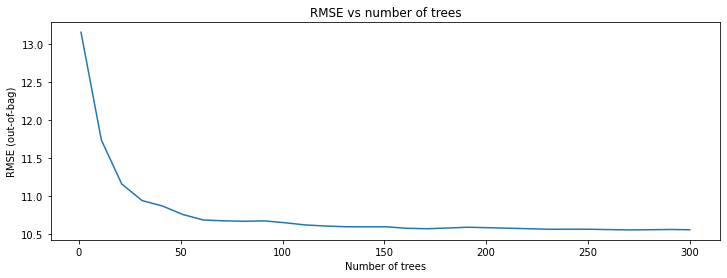

In [ ]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.title("RMSE vs number of trees")

plt.show()

In [ ]:
new_row = {'Model': 'TF-RandomForest', 'MAE': evaluation['mae'], 'MSE': evaluation['mse'], 'RMSE': np.sqrt(evaluation['mse'])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,TF-RandomForest,4.920581,128.098572,11.318064


In [ ]:
# GradientBoostedTree
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
gbt_model.compile(metrics=['mae', 'mse'])
with sys_pipes():
  gbt_model.fit(x=train_ds)

40/46 [=========================>....] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 46
[INFO kernel.cc:393] Number of examples: 2892
[INFO kernel.cc:759] Dataset:
Number of records: 2892
Number of columns: 18

Number of columns by type:
	NUMERICAL: 18 (100%)

Columns:

NUMERICAL: 18 (100%)
	0: "LPM" NUMERICAL mean:70.9934 min:0 max:100 sd:35.7821
	1: "QFE" NUMERICAL mean:1009.74 min:1001.7 max:1014.9 sd:2.05514
	2: "QFF" NUMERICAL mean:1010.35 min:1002.1 max:1015.4 sd:1.87994
	3: "RH0700" NUMERICAL mean:85.6352 min:61 max:100 sd:5.76326
	4: "RH1300" NUMERICAL mean:71.2673 min:48 max:99 sd:6.53325
	5: "RH1800" NUMERICAL mean:77.6272 min:59 max:98 sd:5.55583
	6: "RHrata-rata" NUMERICAL mean:80.166 min:62 max:99 sd:4.68172
	7: "T0700" NUMERICAL mean:25.9017 min:19.8 max:29.2 sd:1.33315
	8: "T1300" NUMERICAL mean:29.5861 min:22.5 max:33.5 sd:1.38866
	9: "T1800" NUMERICAL mean:27.8957 min:22.2 max:31.8 sd:1.35603
	10: "Tmax" NUMERICAL m

46/46 [==============================] - 2s 31ms/step


In [ ]:
# Evaluate
evaluation = gbt_model.evaluate(test_ds, return_dict=True)

print(evaluation)
print('\n')
print(f"MAE: {evaluation['mae']}")
print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")

12/12 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 4.8222 - mse: 132.9712
{'loss': 0.0, 'mae': 4.8222150802612305, 'mse': 132.97120666503906}


MAE: 4.8222150802612305
MSE: 132.97120666503906


In [ ]:
new_row = {'Model': 'TF-GradientBoostedTree', 'MAE': evaluation['mae'], 'MSE': evaluation['mse'], 'RMSE': np.sqrt(evaluation['mse'])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,TF-RandomForest,4.920581,128.098572,11.318064
1,TF-GradientBoostedTree,4.822215,132.971207,11.531314


# XGBoost

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
def xgboost_model():
	hyper_params = {"tree_method":'gpu_hist',
					"n_estimators":2200, 
					"learning_rate":0.01,
					"seed":123,
					"max_depth":20,  
					"objective":'reg:squarederror',  
					"eval_metric":'mae',
					"verbosity":1,
					"booster":'gblinear',
					"reg_alpha":0.4640, 
					"reg_lambda":0.8571,
					"feature_selector":'cyclic',
					"random_state":111,
					"colsample_bytree":0.4603, 
					"gamma":0.0468, 
					"min_child_weight":1.7817,  
					"subsample":0.5213,
					"num_parallel_tree":1
	}
	model = XGBRegressor(**hyper_params)
	return model

def train_xgboost(df_train_features, df_test_features, df_train_label, df_test_label):
	model = xgboost_model()
	model.fit(df_train_features, df_train_label, verbose=2)
	predictions = model.predict(df_test_features)
	evaluation = [mean_absolute_error(df_test_label, predictions), mean_squared_error(df_test_label, predictions)]
	print(evaluation)
	return model, evaluation

In [42]:
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
xgb_model, xgb_evaluation = train_xgboost(df_train_features=train_features, 
																	 df_test_features=test_features, 
																	 df_train_label=train_labels,  
																	 df_test_label=test_labels)

[11:24:23] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[6.440154484335312, 171.86421656337734]


In [32]:
new_row = {'Model': 'XGBoost', 'MAE': xgb_evaluation[0], 'MSE': xgb_evaluation[1], 'RMSE': np.sqrt(xgb_evaluation[1])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network,5.164621,228.349640,15.111242
1,XGBoost,6.440151,171.861669,13.109602


In [43]:
xgb_model.save_model('peramalan-cuaca-bmkg/models/xgb-model-dummy.txt')

In [44]:
model = XGBRegressor()
model.load_model('peramalan-cuaca-bmkg/models/xgb-model-dummy.txt')

In [45]:
predic = model.predict(pred_data)
predic

array([9.205477], dtype=float32)

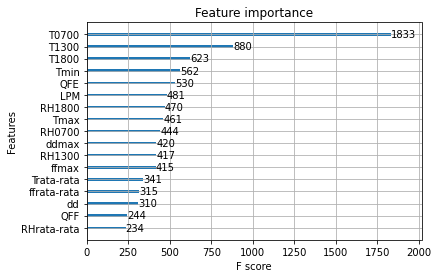

In [ ]:
# Feature Importance in XGBoost
import xgboost as xgb

params = {
      'tree_method': 'gpu_hist',
      'n_estimators': 220, 
      'learning_rate': 0.1,
      'seed': 123,
      'max_depth': 20,  
      'objective': 'reg:squarederror',  
      'eval_metric': 'mae',
      'verbosity': 1,
      'random_state': 111

}

# params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}

data_dmatrix = xgb.DMatrix(data=df_pre[feature_cols], label=df_pre[label_col])

xgb_feature_importance = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_importance(xgb_feature_importance)

In [ ]:
# ['T0700', 'T1300', 'T1800', 'Tmin', 'QFE', 'LPM', 'RH1800', 'Tmax']

# LightGBM

In [46]:
import lightgbm as lgb

In [47]:
def lightgbm_model():
	hyper_params = {"task": "train",
					"boosting_type": "gbdt",
					"objective": "regression",
					"metric": ["l1", "l2"],
					"learning_rate": 0.001,
					"feature_fraction": 0.9,
					"bagging_fraction": 0.7,
					"bagging_freq": 10,
					"verbose": 0,
					"max_depth": 8,
					"num_leaves": 128,  
					"max_bin": 512,
					"num_iterations": 100000
					# "max_bin":55, 
					# "feature_fraction_seed":9, 
					# "bagging_seed":9,
					# "min_data_in_leaf":6, 
					# "min_sum_hessian_in_leaf":11,
	}
	model = lgb.LGBMRegressor(**hyper_params)
	return model

def train_lightgbm(df_train_features, df_test_features, df_train_label, df_test_label):
	model = lightgbm_model()
	model.fit(df_train_features, 
			  df_train_label,
			  eval_set=[(df_test_features, df_test_label)],
			  eval_metric='l2',
			  early_stopping_rounds=1000,
			  verbose=500
	)
	predictions = model.predict(df_test_features)
	evaluation = [mean_absolute_error(df_test_label, predictions), mean_squared_error(df_test_label, predictions)]
	print(evaluation)
	# st.write(evaluation)
	return model, evaluation

In [48]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(2945, 17)
(708, 17)
(2945, 1)
(708, 1)


In [49]:
lgbm_model, lgbm_evaluation = train_lightgbm(df_train_features=train_features, 
																		df_test_features=test_features, 
																		df_train_label=train_labels,  
																		df_test_label=test_labels)

/home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 

In [50]:
new_row = {'Model': 'LightGBM', 'MAE': lgbm_evaluation[0], 'MSE': lgbm_evaluation[1], 'RMSE': np.sqrt(lgbm_evaluation[1])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network,5.164621,228.349640,15.111242
1,XGBoost,6.440151,171.861669,13.109602
2,LightGBM,5.227256,137.344934,11.719426


In [52]:
lgbm_model.booster_.save_model('peramalan-cuaca-bmkg/models/lgbm-model-dummy.txt')

In [54]:
model = lgb.Booster(model_file='peramalan-cuaca-bmkg/models/lgbm-model-dummy.txt')
# model = lgbm_model.Booster(model_file='lgbm-model-dummy.txt')
prediction = model.predict(pred_data)
prediction

array([9.70560178])